<a href="https://colab.research.google.com/github/P4P3RCL1P/HopLogData/blob/main/Log_file_root_cause_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#XGBoost classification

**What is XGBoost?**

XGBoost (Semi-Supervised Gradient Boosting)

* Many weak learners (shallow trees) can together make a more accurate predictor





Gradient Boosting
* Idea: Can a weak learner be modified to become better?
  * Can we transform a series of weak/poor hypotheses into one very good hypothesis?
* First main boosting algorithm: AdaBoost (Adaptive Boosting)
  * Weak learners are decision trees with a single split called decision stumps
  * Observations are weighted based on their difficulty in being classified (observations that are harder to classify are assigned a higher weight)
  * To make predictions majority voting is used based on the ensemble of weak learners and a weight assigned based on their individual accuracy score
* What is gradient boosting?
  * Acts as a statistical framework where the goal is to minimize the loss of the model by adding weak learners using a gradient descent like procedure.
* Components of gradient boosting
  * Loss function (to be optimized)
    * In our case, we use logarithmic loss
    * Gradient boosting is generic enough where different loss functions can be used
  * Weak learner (to make predictions)
    * Uses regression trees to output values for splits which is then added together for subsequent trees to take the output and improve/correct upon it.
  * An additive model (to add learners to minimize the loss function)
    * Since gradient boosting uses a tree structure, weak learners are added to previous parents to enhance/minimize the loss function
    * A fixed number of trees are added or training stops once loss reaches an acceptable level or no longer improves the validation dataset

**Regularization**
* Idea: Reduce the prediction’s sensitivity to individual observations
* Regression that prohibits a more complex/flexible model, avoiding the model becoming greedy in capturing noise found in your dataset. (Helps with overfitting)
**A Unique Regression Tree**
* Before constructing the regression trees we have to create an initial prediction score which will help with the classification/regression task (ex: if we want to classify whether a drug is effective or not we can create a prediction that 0.5 effectiveness is our initial boundary)
* XGBoost Tree
  * For Regression
    * A tree starts as a root node, which maps all the residual data points to it
    * The quality/similarity score is calculated for these data points. 
    * Similarity Score = Similarity Score =Sum of Residuals(data points), SquaredNumber / Number of Residuals + Lambda
      * When the residuals in a node are very different, they cancel each other out and the Similarity Score is relatively small.
      * When the residuals are similar, or there is just one residual, they do not cancel out and the Similarity Score is relatively large.
    * Lambda is a Regularization parameter, used for filtering out noise in the data.
      * When lambda is greater than 0, the similarity scores are smaller
      * The amount of decrease is inversely proportional to the number of residuals in the node
      * When lambda is greater than 0, it is easier to prune leaves because the gain values are smaller.
    * After calculating the similarity for the root first leaf we ask whether or not the similarity could improve if we split the residuals into two different groups. (For our drug effectiveness example, if we split the drugs based on whether their dosage is less than 15mg, will that have an effect on the similarity score?)
    * Residuals are sorted into their new groups based on the condition set
    * To see how much better the leaf branches similarity scores do from the original node’s similarity score we calculate the gain of splitting the residuals into n groups
    * Gain =LeftSimilarity + RightSimilarity-RootSimilarity
    * After the gain for a specific threshold has been calculated we move to a new threshold and perform a similar methodology of calculating the similarity scores and then the gain. We compare the gain scores and choose the best splitting value based on the total gain scores
    * The split with the highest gain score is set as the branch for that tree.
    * Continue splitting while the node contains more than one value
    * Try all the available thresholds for this new split and compute the best split again by comparing all the computed gain scores.
    * If a tree isn’t at the default XGBoost tree level of 6 we prune the tree
      * We prune the tree based on its gain values which we attribute to the parameter  (gamma)
      * Starting with the lowest branch, we subtract the branches gain score from gamma, and if the difference between the gain and gamma is negative, we remove the branch.
    * How are predictions calculated?
      * XGBoost makes new predictions by starting with the initial prediction
      * New prediction  = Original prediction +( The output of the tree (Sum of Residuals / Number of Residuals + Lambda ) + Learning Rate X)
        * (eta) is the learning rate. The default value is 0.3 

In [ ]:
import numpy as np 
import pandas as pd 

#tokenization
from textblob import TextBlob

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# sklearn 
from sklearn import model_selection
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics.pairwise import cosine_similarity


# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
RAW_LOG_DATA_WITH_ERRORS = 'https://raw.githubusercontent.com/P4P3RCL1P/HopLogData/main/3-27-22.txt'

RAW_LOG_DATA_WITHOUT_ERRORS = 'https://raw.githubusercontent.com/P4P3RCL1P/HopLogData/main/3-28-22.txt'

train = pd.read_csv(RAW_LOG_DATA_WITH_ERRORS, sep=' - ', header=None, names =["Time", "Action", "LoggingText", "isError"])
train.head(60)
test = pd.read_csv(RAW_LOG_DATA_WITHOUT_ERRORS, sep=' - ', header=None, names =["Time", "Action", "LoggingText", "isError"])

In [ ]:
test.head(60)

,Time,Action,LoggingText,isError
0,2022/03/28 19:10:19,Hop,Starting workflow,0.0
1,2022/03/28 19:10:19,demoLineage,Start of workflow execution,0.0
2,2022/03/28 19:10:19,demoLineage,Logging workflow information to Neo4j connecti...,0.0
3,2022/03/28 19:10:19,demoLineage,Logging workflow metadata to Neo4j server : Ex...,0.0
4,2022/03/28 19:10:19,demoLineage,Workflow metadata cypher : MERGE (w:Workflow {...,0.0
5,2022/03/28 19:10:19,demoLineage,Action copy 'Start' cypher : MATCH (w:Workflow...,0.0
6,2022/03/28 19:10:19,demoLineage,Action copy 'Check DB connections' cypher : MA...,0.0
7,2022/03/28 19:10:19,demoLineage,Action copy 'Query for recent changes' cypher ...,0.0
8,2022/03/28 19:10:19,demoLineage,Action copy 'insert logging info nodes' cypher...,0.0
9,2022/03/28 19:10:19,demoLineage,Action copy 'Insert logging info relationships...,0.0


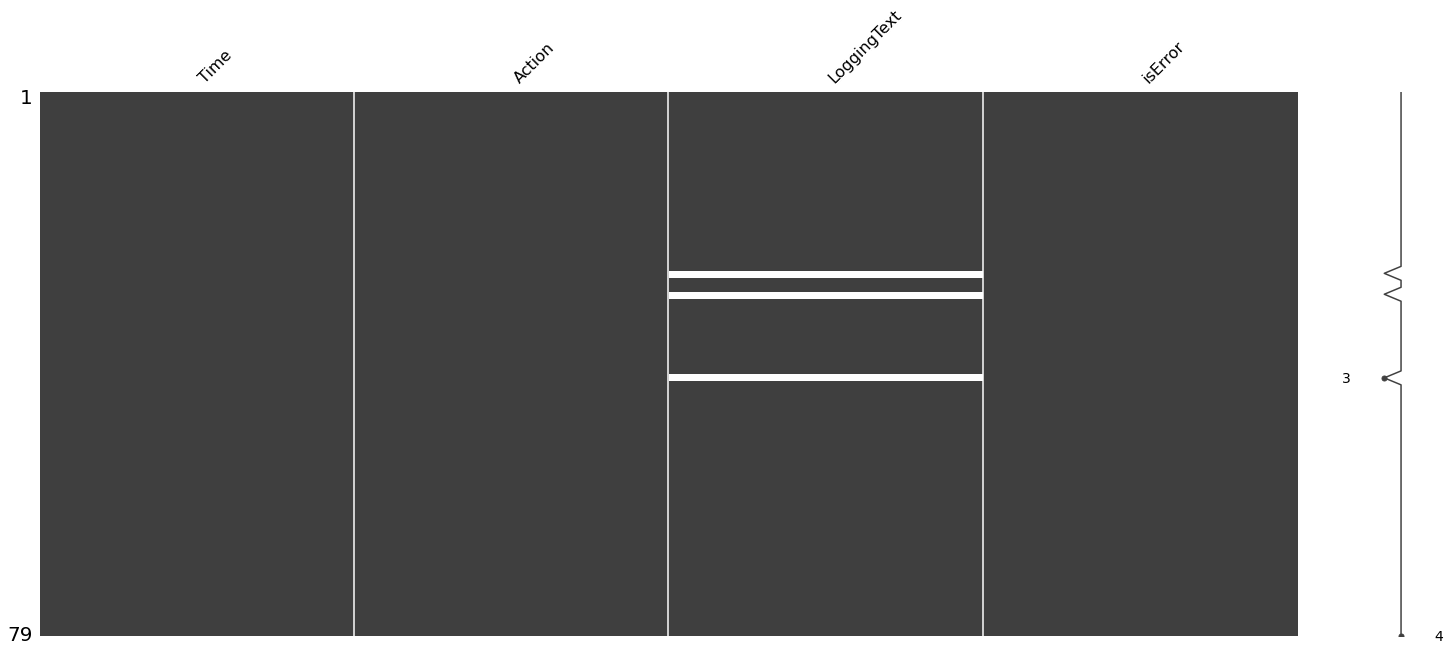

In [ ]:
import missingno as msno
msno.matrix(df=train)

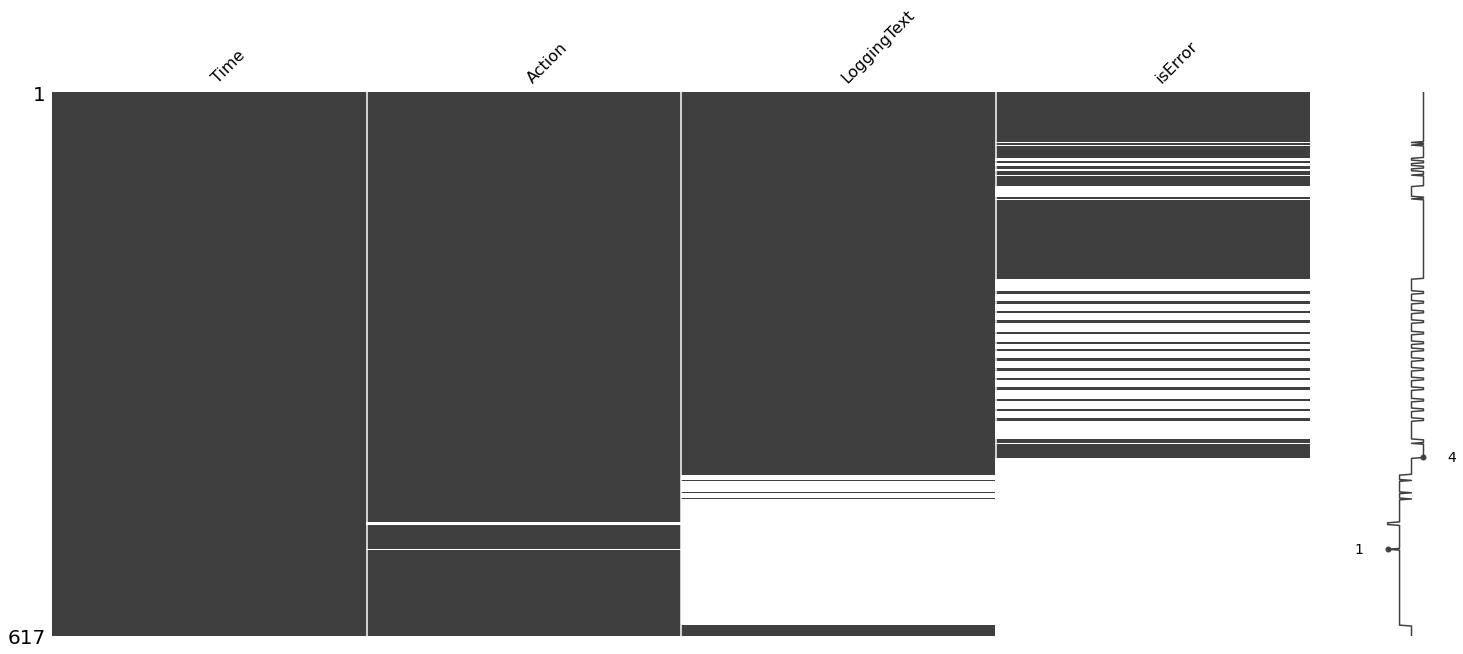

In [ ]:
msno.matrix(df=test)

In [ ]:
train.fillna("", inplace = True)
test.fillna("", inplace = True)
train.head(60)

,Time,Action,LoggingText,isError
0,2022/03/27 11:46:49,Hop,Projects enabled,0
1,2022/03/27 11:46:49,Hop,Enabling project : 'default',0
2,2022/03/27 11:47:45,Hop,Starting workflow,0
3,2022/03/27 11:47:45,demoLineage,Start of workflow execution,0
4,2022/03/27 11:47:45,demoLineage,Logging workflow information to Neo4j connecti...,0
5,2022/03/27 11:47:48,demoLineage,ERROR: Error logging to Neo4j:,1
6,2022/03/27 11:47:48,demoLineage,ERROR: org.neo4j.driver.exceptions.ServiceUnav...,1
7,2022/03/27 11:47:48,demoLineage,\tat org.neo4j.driver.GraphDatabase.routingDri...,1
8,2022/03/27 11:47:48,demoLineage,\tat org.apache.hop.neo4j.shared.NeoConnection...,1
9,2022/03/27 11:47:48,demoLineage,\tat org.apache.hop.neo4j.shared.NeoConnection...,1


In [ ]:
#preprocess for filler data or null values
train["LoggingText"].replace('', np.nan, inplace=True)
train.dropna(subset=['LoggingText'], inplace = True)
test["LoggingText"].replace('',np.nan, inplace=True)
test.dropna(subset=["LoggingText"], inplace = True)
train.head(60)

,Time,Action,LoggingText,isError
0,2022/03/27 11:46:49,Hop,Projects enabled,0
1,2022/03/27 11:46:49,Hop,Enabling project : 'default',0
2,2022/03/27 11:47:45,Hop,Starting workflow,0
3,2022/03/27 11:47:45,demoLineage,Start of workflow execution,0
4,2022/03/27 11:47:45,demoLineage,Logging workflow information to Neo4j connecti...,0
5,2022/03/27 11:47:48,demoLineage,ERROR: Error logging to Neo4j:,1
6,2022/03/27 11:47:48,demoLineage,ERROR: org.neo4j.driver.exceptions.ServiceUnav...,1
7,2022/03/27 11:47:48,demoLineage,\tat org.neo4j.driver.GraphDatabase.routingDri...,1
8,2022/03/27 11:47:48,demoLineage,\tat org.apache.hop.neo4j.shared.NeoConnection...,1
9,2022/03/27 11:47:48,demoLineage,\tat org.apache.hop.neo4j.shared.NeoConnection...,1


In [ ]:
train = train[train["LoggingText"].str.contains(r'^(?=.*=======================================)')==False]
train = train[train["LoggingText"].str.contains(r'^]')==False]

test = test[test["LoggingText"].str.contains(r'^(?=.*=======================================)')==False]
test = test[test["LoggingText"].str.contains(r'^]')==False]


In [ ]:
train.shape

(73, 4)

In [ ]:
test.shape

(447, 4)

In [ ]:
train.head(60)

,Time,Action,LoggingText,isError
0,2022/03/27 11:46:49,Hop,Projects enabled,0
1,2022/03/27 11:46:49,Hop,Enabling project : 'default',0
2,2022/03/27 11:47:45,Hop,Starting workflow,0
3,2022/03/27 11:47:45,demoLineage,Start of workflow execution,0
4,2022/03/27 11:47:45,demoLineage,Logging workflow information to Neo4j connecti...,0
5,2022/03/27 11:47:48,demoLineage,ERROR: Error logging to Neo4j:,1
6,2022/03/27 11:47:48,demoLineage,ERROR: org.neo4j.driver.exceptions.ServiceUnav...,1
7,2022/03/27 11:47:48,demoLineage,\tat org.neo4j.driver.GraphDatabase.routingDri...,1
8,2022/03/27 11:47:48,demoLineage,\tat org.apache.hop.neo4j.shared.NeoConnection...,1
9,2022/03/27 11:47:48,demoLineage,\tat org.apache.hop.neo4j.shared.NeoConnection...,1


In [ ]:
#row number was not sequential after regex so reset indices
train.reset_index()

,index,Time,Action,LoggingText,isError
0,0,2022/03/27 11:46:49,Hop,Projects enabled,0
1,1,2022/03/27 11:46:49,Hop,Enabling project : 'default',0
2,2,2022/03/27 11:47:45,Hop,Starting workflow,0
3,3,2022/03/27 11:47:45,demoLineage,Start of workflow execution,0
4,4,2022/03/27 11:47:45,demoLineage,Logging workflow information to Neo4j connecti...,0
...,...,...,...,...,...
68,74,2022/03/27 11:47:54,demoLineage,Finished action [DB CONNECTION ERRORS] (result...,0
69,75,2022/03/27 11:47:54,demoLineage,Finished action [Check DB connections] (result...,0
70,76,2022/03/27 11:47:54,demoLineage,Workflow execution finished,0
71,77,2022/03/27 11:47:54,Hop,Workflow execution has ended,0


In [ ]:
test.reset_index()

,index,Time,Action,LoggingText,isError
0,0,2022/03/28 19:10:19,Hop,Starting workflow,0.0
1,1,2022/03/28 19:10:19,demoLineage,Start of workflow execution,0.0
2,2,2022/03/28 19:10:19,demoLineage,Logging workflow information to Neo4j connecti...,0.0
3,3,2022/03/28 19:10:19,demoLineage,Logging workflow metadata to Neo4j server : Ex...,0.0
4,4,2022/03/28 19:10:19,demoLineage,Workflow metadata cypher : MERGE (w:Workflow {...,0.0
...,...,...,...,...,...
442,612,2022/03/28 19:10:20-moLineage,Finished action [Check DB connections] (result...,0,
443,613,2022/03/28 19:10:20-moLineage,Workflow execution finished,0,
444,614,2022/03/28 19:10:20-p,Workflow execution has ended,0,
445,615,2022/03/28 19:10:20-moLineage,"Workflow duration : 1.015 seconds [ 1.014"" ]",0,


In [ ]:
train['Action'].describe()

count              73
unique              9
top       demoLineage
freq               33
Name: Action, dtype: object

In [ ]:
print(train.dtypes)

Time           object
Action         object
LoggingText    object
isError         int64
dtype: object


# Classification using RegEx

Using RegEx assumes knowledge of the system environment and of areas where issues can occur. Our question is whether we can perform classification of whether a line in our log file is an error with minimal knowledge of the system domain. This acts as an introduction for how we can classify whether something is an error or not, but is not beneficial in real life instances when domain knowledge of the system is lacking.


In [ ]:
regExErrorClass = train[['LoggingText']].copy()


#classify text as containing errors if the following keywords are present
regList = [('Error'), ('ERROR:'), ('\tat ')]
for r in regList:
  #if any string in the Logging Text column contains or matches any of the regular expressions classify it as 1 for True
  regExErrorClass.loc[regExErrorClass['LoggingText'].str.contains(r[0], regex = False) == True, 'isError'] = 1

#fill in all other values as false (they didn't meet the regex criteria)
regExErrorClass['isError'] = regExErrorClass['isError'].replace("", 0)
regExErrorClass['isError'].fillna(0, inplace = True)


In [ ]:
regExErrorClass

,LoggingText,isError
0,Projects enabled,0.0
1,Enabling project : 'default',1.0
2,Starting workflow,0.0
3,Start of workflow execution,0.0
4,Logging workflow information to Neo4j connecti...,1.0
...,...,...
74,Finished action [DB CONNECTION ERRORS] (result...,1.0
75,Finished action [Check DB connections] (result...,0.0
76,Workflow execution finished,0.0
77,Workflow execution has ended,0.0


In [ ]:
#compare the predicted labels against the training dataset labels to determine the model accuracy/f1/recall/precision
print("Classification metrics:")
y_pred = regExErrorClass['isError']
y_pred = y_pred.astype(np.int64)
y_true = train['isError']
y_true = y_true.astype(np.int64)

print(f"Accuracy score: {accuracy_score(y_true, y_pred)}")
print(f"F1 score: {f1_score(y_true, y_pred)}")
print(f"Recall: {recall_score(y_true, y_pred)} ")
print(f"Precision: {precision_score(y_true, y_pred)} ")

Classification metrics:
Accuracy score: 0.9452054794520548
F1 score: 0.9565217391304348
Recall: 0.9166666666666666 
Precision: 1.0 


A better classification model using regular expressions requires a more in-depth understanding of the structure behind the log file which can become cumbersome and time consuming. Instead, can we automate a classification model without any knowledge about the inherit structure of the logs?

# NLP (Natural language processing) preprocessing strategy

In order to build our classification model, we need data to feed it. Log data presents an interesting problem since most of the data is presented in a string format. To combat this issue we introduce natural language processing which helps detect patterns in our logging text, and which can then be used in classification of where errors are present.

In [ ]:
train['LoggingText'] = train['LoggingText'].replace([None], [""], regex=True)
test['LoggingText'] = test['LoggingText'].replace([None], [""], regex=True)

In [ ]:
train.head(40)

,Time,Action,LoggingText,isError
0,2022/03/27 11:46:49,Hop,Projects enabled,0
1,2022/03/27 11:46:49,Hop,Enabling project : 'default',0
2,2022/03/27 11:47:45,Hop,Starting workflow,0
3,2022/03/27 11:47:45,demoLineage,Start of workflow execution,0
4,2022/03/27 11:47:45,demoLineage,Logging workflow information to Neo4j connecti...,0
5,2022/03/27 11:47:48,demoLineage,ERROR: Error logging to Neo4j:,1
6,2022/03/27 11:47:48,demoLineage,ERROR: org.neo4j.driver.exceptions.ServiceUnav...,1
7,2022/03/27 11:47:48,demoLineage,\tat org.neo4j.driver.GraphDatabase.routingDri...,1
8,2022/03/27 11:47:48,demoLineage,\tat org.apache.hop.neo4j.shared.NeoConnection...,1
9,2022/03/27 11:47:48,demoLineage,\tat org.apache.hop.neo4j.shared.NeoConnection...,1


In [ ]:
test.head()

,Time,Action,LoggingText,isError
0,2022/03/28 19:10:19,Hop,Starting workflow,0.0
1,2022/03/28 19:10:19,demoLineage,Start of workflow execution,0.0
2,2022/03/28 19:10:19,demoLineage,Logging workflow information to Neo4j connecti...,1.0
3,2022/03/28 19:10:19,demoLineage,Logging workflow metadata to Neo4j server : Ex...,1.0
4,2022/03/28 19:10:19,demoLineage,Workflow metadata cypher : MERGE (w:Workflow {...,1.0


In [ ]:
print(train['isError'].value_counts())

1    39
0    34
Name: isError, dtype: int64


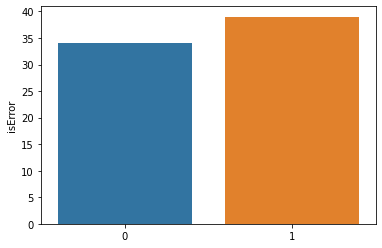

In [ ]:
#distribution among errors and non-errors is roughly equal
sns.barplot(train['isError'].value_counts().index, train['isError'].value_counts())

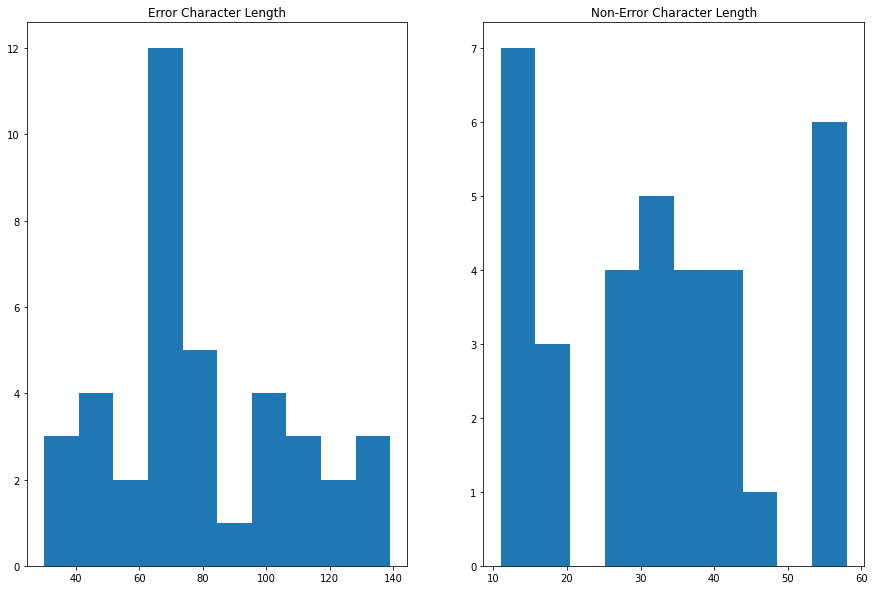

In [ ]:
#how do the character lengths for logs w/ errors compare to non-error log messages
errorCharLen = train[train['isError']==1]['LoggingText'].str.len()
nonErrorCharLen = train[train['isError']==0]['LoggingText'].str.len()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 10))

ax1.hist(errorCharLen)
ax1.set_title("Error Character Length")

ax2.hist(nonErrorCharLen)
ax2.set_title("Non-Error Character Length")

plt.show()

The non-error character length histogram is being overwhelmed by values which don't contain text. Future preprocessing should remove these lines from the dataset since they don't add to the classification model

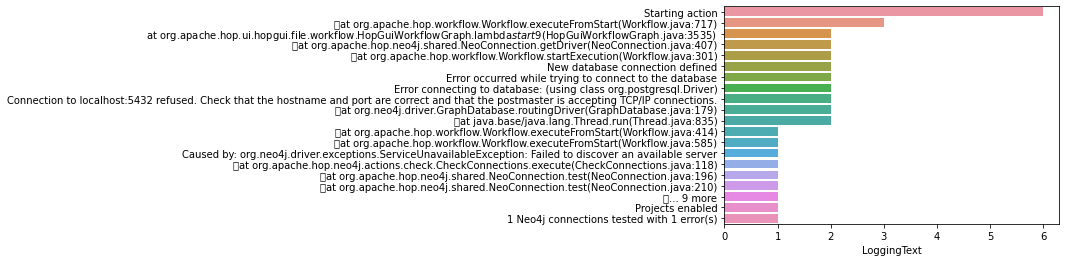

In [ ]:
#Top 20 words based on prevalence in the log file
sns.barplot(y = train['LoggingText'].value_counts()[:20].index, x=train['LoggingText'].value_counts()[:20])

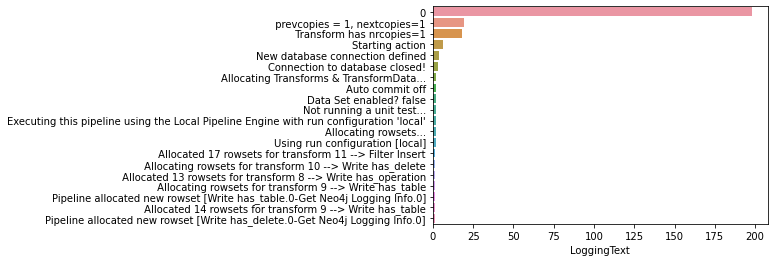

In [ ]:
sns.barplot(y = test['LoggingText'].value_counts()[:20].index, x=test['LoggingText'].value_counts()[:20])



**What is count vectorization?**

Count all the occurences in a document or paragraph and keep track of the count of these words in a 'bag-of-words' to be used for future analysis

In the below example we perform count vectorization without tokenization. Tokenization is used to break larger text into words or sentences, while additionaly normalizing the data to remove punctuation and filler words. Tokenization allows the model to better understand the sequence of words for a given line in our log file.



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
loggingTextList = []
#test = ['Projects enabled' "Enabling project : 'default'" 'Starting workflow' 'Start of workflow execution' 'Logging workflow information to Neo4j connection : Example' 'ERROR: Error logging to Neo4j:' 'ERROR: org.neo4j.driver.exceptions.ServiceUnavailableException: Failed to discover an available server', '\tat org.neo4j.driver.GraphDatabase.routingDriver(GraphDatabase.java:179)', '\tat org.apache.hop.neo4j.shared.NeoConnection.getDriver(NeoConnection.java:407)', '\tat org.apache.hop.neo4j.shared.NeoConnection.getSession(NeoConnection.java:175)', '\tat org.apache.hop.neo4j.logging.xp.WorkflowLoggingExtensionPoint.callExtensionPoint(WorkflowLoggingExtensionPoint.java:87)', '\tat org.apache.hop.neo4j.logging.xp.WorkflowLoggingExtensionPoint.callExtensionPoint(WorkflowLoggingExtensionPoint.java:49)', '\tat org.apache.hop.core.extension.ExtensionPointMap.callExtensionPoint(ExtensionPointMap.java:147)', '\tat org.apache.hop.core.extension.ExtensionPointHandler.callExtensionPoint(ExtensionPointHandler.java:38)', '\tat org.apache.hop.workflow.Workflow.executeFromStart(Workflow.java:368)', '\tat org.apache.hop.workflow.Workflow.startExecution(Workflow.java:301)', '\tat org.apache.hop.ui.hopgui.file.workflow.HopGuiWorkflowGraph.lambda$start$9(HopGuiWorkflowGraph.java:3535)', '\tat java.base/java.lang.Thread.run(Thread.java:835)', 'exec(0, 0, Start)', 'Starting action', 'Starting action [Check DB connections]', 'exec(1, 0, Check DB connections)', 'Starting action', 'New database connection defined', 'ERROR: Cannot connect to database [dvdrental] (connection [dvdrental]). Exception : [org.apache.hop.core.exception.HopDatabaseException:', 'Error occurred while trying to connect to the database', '', 'Error connecting to database: (using class org.postgresql.Driver)' 'Connection to localhost:5432 refused. Check that the hostname and port are correct and that the postmaster is accepting TCP/IP connections.' '' ']' '=======================================']

for key, value in test.iterrows(): 
  #remove logging text that doesn't conain valuable keywords (ex: ==========, ], [)
  loggingTextList.append(value[2])
  try:
    vectorizer.fit([value[2]])
  except:
    continue
  else:
    vectorizer.fit([value[2]])
  #print(vectorizer.vocabulary_)




#may not need this after preprocessing for None, Boolean, and other unnecessary logging text values
loggingTextStr = "\n ".join(loggingTextList)
X = vectorizer.fit_transform(loggingTextList)
vector = vectorizer.vocabulary_
print(vector)



{'starting': 173, 'workflow': 204, 'start': 171, 'of': 137, 'execution': 77, 'logging': 121, 'information': 105, 'to': 185, 'neo4j': 127, 'connection': 52, 'example': 73, 'metadata': 124, 'server': 166, 'cypher': 56, 'merge': 123, 'name': 126, 'workflowname': 205, 'set': 167, 'filename': 80, 'description': 63, 'action': 32, 'copy': 55, 'match': 122, 'rel': 155, 'action_of_workflow': 33, 'pluginid': 145, 'evaluation': 72, 'launchingparallel': 116, 'unconditional': 194, 'locationx': 119, 'locationy': 120, 'check': 43, 'db': 59, 'connections': 53, 'query': 150, 'for': 85, 'recent': 154, 'changes': 42, 'insert': 108, 'info': 104, 'nodes': 131, 'relationships': 156, 'errors': 71, 'exec': 74, 'new': 129, 'database': 58, 'defined': 61, 'connected': 51, 'dvdrental': 66, 'we': 199, 'can': 41, 'successfully': 175, 'connect': 50, 'closed': 45, 'were': 200, 'in': 103, 'error': 70, 'checked': 44, 'running': 162, 'sql': 170, 'select': 165, 'from': 87, 'table_history': 178, 'where': 201, 'tstamp': 19

In [ ]:
pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())

,02,029499000,03,08,09,10,11,114,12,13,...,using,variables,we,were,where,with,without,workflow,workflowname,write
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
443,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
444,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
445,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**TF-IDF (Term Frequency - Inverse Document Frequency)** Quantifies the importance or relevance of string representations in a document (Percentage of words contained in a given string)

Since longer lines of text can be assigned a higher weight than lines of text with only a short number of words in count vectorization we should prefer TF-IDF.

TF (Term Frequency) = # of times the term appears / number of terms

IDF  =  1 + log(number of documents (N) /n (number of documents a term has appeared in))
*   Determines how rare o common an item is in a given document
*   For stop words the IDF will be low, making this process more valuable since we don't want the model to be overwhelmed by filler words which don't add to the classification.  



We can use this to quantify the frequency of keywords synonymous with errors





In [ ]:
#for now, we use TF-IDF without idf to gain a simple understanding of the different terms contained in the document.
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(use_idf= False, norm='l1')
X = vectorizer.fit_transform(loggingTextList)
termFrequencyDf = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names_out())
termFrequencyDf

,02,029499000,03,08,09,10,11,114,12,13,...,using,variables,we,were,where,with,without,workflow,workflowname,write
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.083333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [ ]:
#Sort the dataframe based on how frequent the term 'error' is found. Apparently line 47 contains the highest term frequency for 'error'
highestErrorCount = termFrequencyDf.sort_values(by='error', ascending = False)
highestErrorCount

,02,029499000,03,08,09,10,11,114,12,13,...,using,variables,we,were,where,with,without,workflow,workflowname,write
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0
47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000,0.0,0.00,0.0,0.0,0.2,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000,0.0,0.00,0.0,0.0,0.0,0.5,0.0,0.0
295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.125,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.125,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0


Further preprocessing to link words together and reduce it to its root word.

The textblob library is used to easily tokenize our data.

We tokenize the list to string runs of text that should be considered words:

**Examples that should be tokenized:**

*  org.apache.hop.core.extension.extensionpointhandler.callextensionpoint
*   org.neo4j.driver.exceptions.serviceunavailableexcept

In [ ]:
#install dependencies
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [ ]:
#break larger text into smaller chunks (tokens)
def tokenize(loggingText):
  blob = TextBlob(loggingText.lower())
  tokens = blob.words
  words = [token.stem() for token in tokens]
  return words

vectorizer = CountVectorizer(tokenizer=tokenize)
testVector = vectorizer.fit_transform(loggingTextList)
trainVector = vectorizer.transform(loggingTextList)
testVectorDf = pd.DataFrame(testVector.toarray(), columns = vectorizer.get_feature_names_out())
testVectorDf

,'12,'check,'db,'get,'insert,'local,'neo4j,'queri,'read,'sort,...,w.descript,w.filenam,we,were,where,with,without,workflow,workflownam,write
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
443,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
444,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
445,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#for column in tokenizedDf.columns:
  #print(column)
testVectorDf.shape

(447, 252)

# Count Vectorization with tokenization and removing stop words

Using textblob tokenization also includes **stemming**: removing and replacing suffixes to get to the root form of the word which is useful for words which contain multiple suffixes (database, databas(es), connection, connection(s), etc.)

**Remove stop words**

We want to be able to remove common words that don't pertain to our analysis (was, are, is, etc.). Initializing the 'stop_words' parameter can allow us to do so. 

In [ ]:
vectorizer = CountVectorizer(tokenizer = tokenize, stop_words = 'english')
trainVector = vectorizer.fit_transform(train['LoggingText'])
#testVector = vectorizer.fit_transform(loggingTextList)
#trainVector = vectorizer.transform(loggingTextList)
trainVectorDf = pd.DataFrame(trainVector.toarray(), columns = vectorizer.get_feature_names_out())
#testVectorDf
trainVectorDf


,'default,'exampl,0,1,2,3,4,9,9.324,9.325,...,unabl,use,workflow,workflow.java:301,workflow.java:368,workflow.java:414,workflow.java:585,workflow.java:717,workflowloggingextensionpoint.java:49,workflowloggingextensionpoint.java:87
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
71,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
#todense returns a matrix, which we can use for our XGBoost classification model
X= vectorizer.transform(train['LoggingText']).todense()
y = train['isError'].values

#Count Vectorization Visualization


Use n-gram analysis to visualize the common bigrams and trigrams witih

In [ ]:
def get_top_logging_text_bigrams(text, n=None):
    bigramVec = CountVectorizer(ngram_range=(2,2)).fit(text)
    X_bigram = bigramVec.transform(text)
    sum_words = X_bigram.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in bigramVec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

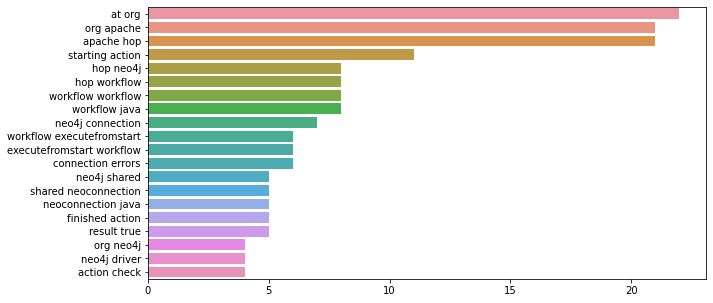

In [ ]:
plt.figure(figsize=(20,10))
top_logging_text_bigrams = get_top_logging_text_bigrams(train['LoggingText'])[:20]
x,y=map(list,zip(*top_logging_text_bigrams))
sns.barplot(x=y, y=x)

In [ ]:
def get_top_logging_text_trigrams(text, n=None):
    trigramVec = CountVectorizer(ngram_range=(3,3)).fit(text)
    X_trigram = trigramVec.transform(text)
    sum_words = X_trigram.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in trigramVec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

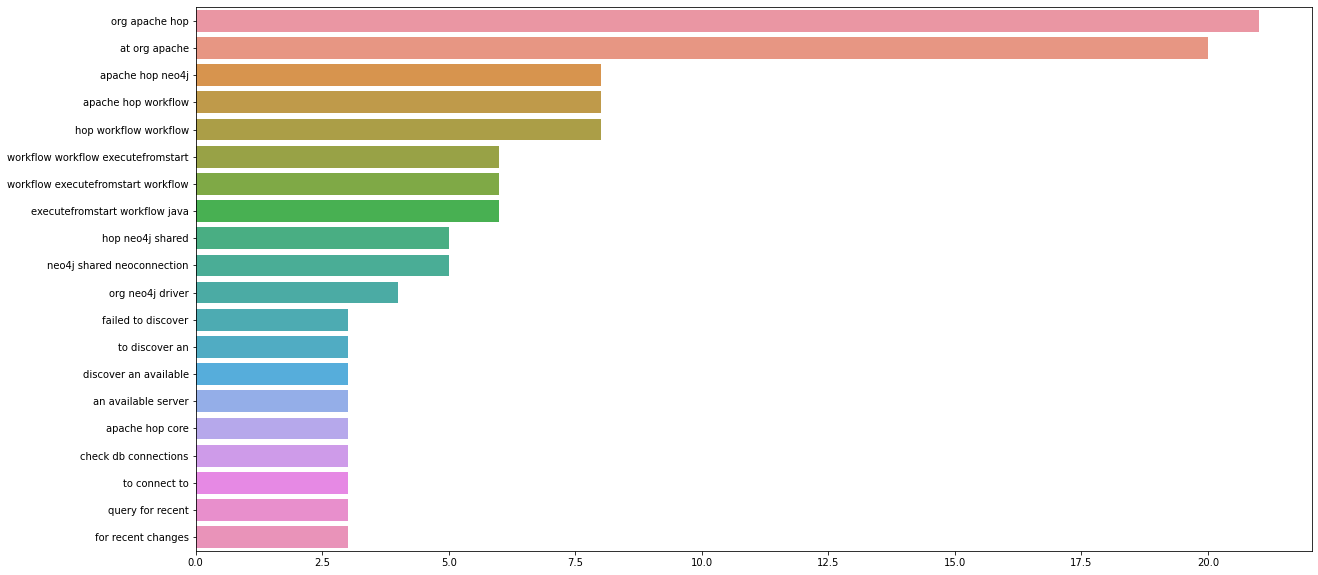

In [ ]:
plt.figure(figsize=(20,10))
top_logging_text_trigrams = get_top_logging_text_trigrams(train['LoggingText'])[:20]
x,y=map(list,zip(*top_logging_text_trigrams))
sns.barplot(x=y, y=x)

#Count Vectorization Classification (Using XGBoost)

In [ ]:
clfXGB = XGBClassifier(max_depth = 8, 
                       n_estimators= 2000, 
                       colsample_bytree=0.85, 
                       subsample=0.8, 
                       nthread=10, 
                       learning_rate =0.1,
                       gamma=0.4,
                       objective='binary:logistic',
                       eval_metric=['auc','logloss','error'],
                       early_stopping_round=50)

In [ ]:

#X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.5, random_state=42)
#X_train.shape, X_test.shape

kfold = KFold(n_splits = 10, shuffle=True, random_state=42);
accuracyScores = []
f1Scores = []
for train_index, test_index in kfold.split(X):
  X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
  clfXGB.fit(X_train, y_train)
  y_pred_xgb = clfXGB.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred_xgb)
  f1 = f1_score(y_test, y_pred_xgb)
  f1Scores.append(f1)
  accuracyScores.append(accuracy)

print(f"Accuracy: {np.mean(accuracyScores)}")
print(f"F1 Score: {np.mean(f1Scores)}")

Accuracy: 0.8785714285714287
F1 Score: 0.8693217893217893


In [ ]:
#which features provide the greatest importance when classifying the logging text?
xgb_fea_imp=pd.DataFrame(list(clfXGB.get_booster().get_fscore().items()),
columns=['feature','importance']).sort_values('importance', ascending=False)
print('',xgb_fea_imp)

   feature  importance
4     f18         105
3     f28          60
0     f11          38
2     f86          13
5     f76          12
8      f2          11
6     f35           3
7     f20           3
1     f15           1
9     f45           1


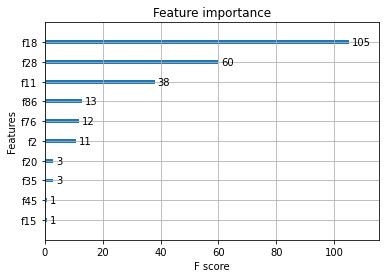

In [ ]:
#apparently feature 18, but what is feature 18?
from xgboost import plot_importance
plot_importance(clfXGB)

In [ ]:
column =trainVectorDf.columns[18]
print(column)

connect


In [ ]:
column = trainVectorDf.columns[28]
print (column)

error


In [ ]:
column = trainVectorDf.columns[76]
print (column)

start


#TF-IDF Classification (Using XGBoost)

Performing TF-IDF results in a slightly higher performance result 

In [ ]:
#Using new tokenization and stop words on TF-IDF
vectorizer = TfidfVectorizer(tokenizer=tokenize, stop_words ='english', use_idf=False)

#testTFIDF = vectorizer.fit_transform(loggingTextList)
X = vectorizer.fit_transform(train['LoggingText'])

#testTFIDFDf = pd.DataFrame(testTFID.toarray(), columns=vectorizer.get_feature_names_out())
#test = termFrequencyDf.sort_values(by='error', ascending = False)
#test

trainTFIDFDf = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names_out())
trainTFIDFDf

,'default,'exampl,0,1,2,3,4,9,9.324,9.325,...,unabl,use,workflow,workflow.java:301,workflow.java:368,workflow.java:414,workflow.java:585,workflow.java:717,workflowloggingextensionpoint.java:49,workflowloggingextensionpoint.java:87
0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.57735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.707107,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.577350,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.408248,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.577350,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y = train['isError'].values

In [ ]:
clfXGB = XGBClassifier(max_depth = 8, 
                       n_estimators= 2000, 
                       colsample_bytree=0.85, 
                       subsample=0.8, 
                       nthread=10, 
                       learning_rate =0.1,
                       gamma=0.4,
                       objective='binary:logistic',
                       eval_metric=['auc','logloss','error'],
                       early_stopping_round=50)

In [ ]:
kfold = KFold(n_splits = 10, shuffle=True, random_state=42);
accuracyScores = []
f1Scores = []
for train_index, test_index in kfold.split(X):
  X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
  clfXGB.fit(X_train, y_train)
  y_pred_xgb = clfXGB.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred_xgb)
  f1 = f1_score(y_test, y_pred_xgb)
  f1Scores.append(f1)
  accuracyScores.append(accuracy)

print(f"Accuracy: {np.mean(accuracyScores)}")
print(f"F1 Score: {np.mean(f1Scores)}")

Accuracy: 0.9339285714285716
F1 Score: 0.9296031746031748


In [ ]:
y_pred_xgb = clfXGB.predict(X_test)

In [ ]:
#which features provide the greatest importance when classifying the logging text?
xgb_fea_imp=pd.DataFrame(list(clfXGB.get_booster().get_fscore().items()),
columns=['feature','importance']).sort_values('importance', ascending=False)
print('',xgb_fea_imp)

    feature  importance
4      f18          98
5      f28          52
0      f11          27
7      f76          14
3      f86          13
6       f2          10
10     f20           2
1      f31           1
2      f15           1
8      f35           1
9      f45           1


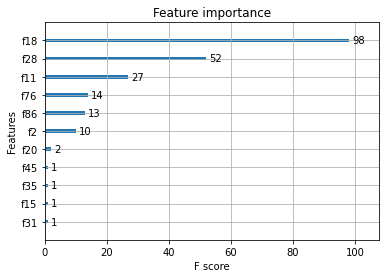

In [ ]:
#apparently feature 18, but what is feature 18?
from xgboost import plot_importance
plot_importance(clfXGB, )

In [ ]:
column =trainTFIDFDf.columns[18]
print(column)

connect


In [ ]:
column =trainTFIDFDf.columns[28]
print(column)

error


In [ ]:
column =trainTFIDFDf.columns[76]
print(column)

start


# TF-IDF visualization

([<matplotlib.axis.YTick at 0x7ff44ca9d110>,
 [Text(0, 0, 'connect'),
  Text(0, 0, 'start'),
  Text(0, 0, 'action'),
  Text(0, 0, 'error'),
  Text(0, 0, 'org.apache.hop.workflow.workflow.executefromstart'),
  Text(0, 0, 'neo4j'),
  Text(0, 0, 'check'),
  Text(0, 0, '0'),
  Text(0, 0, 'databas'),
  Text(0, 0, 'workflow')])

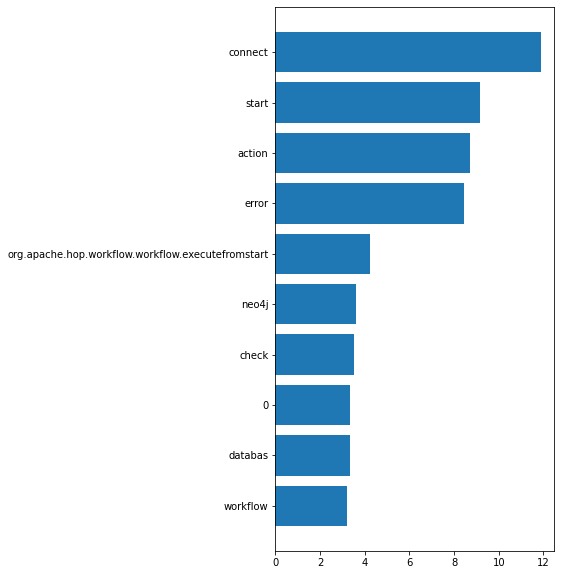

In [ ]:
#get 10 most prevalent keywords in logging text
featuresRank = list(zip(vectorizer.get_feature_names_out(), [x[0] for x in X.sum(axis=0).T.tolist()]))

featuresRank = np.array(sorted(featuresRank, key=lambda x:x[1], reverse=True))

n=10
plt.figure(figsize=(5,10))
plt.barh(-np.arange(n),featuresRank[:n, 1].astype(float), height =0.8)
plt.yticks(ticks=-np.arange(n), labels=featuresRank[:n, 0])

In [ ]:
train['LoggingText'] 

In [ ]:
for column in trainTFIDFDf.columns:
  print(column)

'default
'exampl
0
1
2
3
4
9
9.324
9.325
accept
action
avail
caus
chang
check
checkconnections.java:118
class
connect
correct
databas
db
defin
discov
durat
dvdrental
enabl
end
error
exampl
exec
execut
extensionpointhandler.java:38
extensionpointmap.java:147
fail
finish
graphdatabase.java:179
ha
hopguiworkflowgraph.java:3535
hostnam
inform
java.base/java.lang.thread.run
java.lang.except
localhost:5432
log
neo4j
neoconnection.java:175
neoconnection.java:196
neoconnection.java:210
neoconnection.java:407
new
occur
org.apache.hop.core.exception.hopdatabaseexcept
org.apache.hop.core.extension.extensionpointhandler.callextensionpoint
org.apache.hop.core.extension.extensionpointmap.callextensionpoint
org.apache.hop.neo4j.actions.check.checkconnections.execut
org.apache.hop.neo4j.logging.xp.workflowloggingextensionpoint.callextensionpoint
org.apache.hop.neo4j.shared.neoconnection.getdriv
org.apache.hop.neo4j.shared.neoconnection.getsess
org.apache.hop.neo4j.shared.neoconnection.test
org.apache.

## Comparing Frequency with Common Keywords

 How does the frequency between common keywords synonymous with the line being an error

In [ ]:
#from sklearn.metrics.pairwise import cosine_similarity
#termSim = termFrequencyDf.corr().abs()

#upper = termSim.where(np.triu(np.ones(termSim.shape), k=1).astype(bool))


#dropFeatures = [column for column in upper.columns if any(upper[column] > 0.95)]


#termFrequencyDf.drop(dropFeatures, axis=1, inplace =True)
#termFrequencyDf

In [ ]:
termFrequencyDf[['error', 'neo4j']]

,error,neo4j
0,0.0,0.000000
1,0.0,0.000000
2,0.0,0.142857
3,0.0,0.142857
4,0.0,0.000000
...,...,...
442,0.0,0.000000
443,0.0,0.000000
444,0.0,0.000000
445,0.0,0.000000


In [ ]:
termFrequencyDf[['error','connect']]

,error,connect
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
442,0.0,0.0
443,0.0,0.0
444,0.0,0.0
445,0.0,0.0


In [ ]:
termFrequencyDf[['error', 'tcp/ip']]

KeyError: ignored

In [ ]:
trainTFIDFDf[['error','db']]

In [ ]:
trainTFIDFDf.error + trainTFIDFDf.neo4j

In [ ]:
errorsByCorrelation = pd.DataFrame({
    'error': test.error,
    'neo4j': test.neo4j,
    'database':test.db,
    'connection': test.connect,
    'error + neo4j': test.error + test.neo4j,
    'error + database': test.db + test.error,
    'error + connection': test.error + test.connect
})
errorsByCorrelation.head(20)

In [ ]:
train.iloc[[47,5,39,32,71,40,25,65,27,66,42,6,42,6,72,68,74,64]]

#Error Classification (Using BERT)


In [ ]:
#bert prerequisites
!pip install bert-for-tf2

     |████████████████████████████████| 41 kB 127 kB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30535 sha256=aff6fba5eeee601535f75cc472e6cb2a29c87adc81afd40fb005031901527e42
  Stored in directory: /root/.cache/pip/wheels/47/b6/e5/8c76ec779f54bc5c2f1b57d2200bb9c77616da83873e8acb53
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19472 sha256=398514230fed231d580433f55382e45a0f53643c146f918f13c35b94b58da941
  Stored in directory: /root/.cache/pip/wheels/0e/fc/d2/a44fff33af0f233d7def6e7de413006d57c10e10ad736fe8f5
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7911 sha256=20c9bfc3ac6d04a5695dd638f65803d215ee45fb088112ee6bc414699a8f7ac7
  Stored in directory: /root/.cache/pip/wheels/e1/11/67/33cc51bbee127cb8fb2ba549cd29109b2f22da43ddf9969716
Successfully built bert-for-tf2 params-flow py-params


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
import tensorflow_hub as hub

try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers
import bert

In [ ]:
#keras model does not have an F1 score, as such we must define our own functions for calculating the F1 score
#src: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
#bidirectional encoder representations from transformers (BERT)
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [ ]:
def bert_encode(texts, tokenizer, max_len=50):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
def encode_sentence(s):
  tokens = list(tokenizer.tokenize(s))
  tokens.append('[SEP]')
  token_ids=tokenizer.convert_tokens_to_ids(tokens)
  return token_ids

In [ ]:
def bert_encode(texts, tokenizer, max_len=50):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocab_file, do_lower_case)

In [ ]:
learning_rate=1e-5
decay=5e-5
max_len=50
lr_schedule = [9e-7,1e-8,5e-8,9e-8,7e-9,1e-9]
K.clear_session()

In [ ]:
input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
segment_ids = Input(shape=(max_len), dtype=tf.int32, name="segment_ids")
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
clf_output = sequence_output[:, 0, :]

out = Dense(1024, activation='relu', activity_regularizer=regularizers.l2(1e-5))(clf_output)
out = Dense(1024, activation='relu', activity_regularizer=regularizers.l2(1e-5))(out)
out = Dense(1024, activation='relu', activity_regularizer=regularizers.l2(1e-5))(out)

out = Dense(1, activation='sigmoid')(out)

In [ ]:
sBERT = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
# sBERT.compile(SGD(lr=learning_rate, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
sBERT.compile(Adam(lr=learning_rate, decay=decay), loss='binary_crossentropy', metrics=['accuracy',f1_m])
sBERT.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 50)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 50)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 1024),       335141889   ['input_word_ids[0][0]',         
                                 (None, 50, 1024)]                'input_mask[0][0]',       

In [ ]:
init_weights = sBERT.get_weights()

In [ ]:
checkpoint1 = ModelCheckpoint('best_accuracy.h5',
                             monitor='val_f1_m',
                             save_best_only=True)
kfold = KFold(n_splits = 10, shuffle=True, random_state=42);
a=1
scores =[]
for train_index, test_index in kfold.split(train,y):
  print(f"==========FOLD: {a}==========")
  K.set_value(sBERT.optimizer.lr, 1e-7)
  train_input  = bert_encode(train.iloc[train_index].LoggingText.values, tokenizer, max_len = 50)
  train_labels = y[train_index]

  test_input = bert_encode(train.iloc[test_index].LoggingText.values, tokenizer, max_len = 50)
  test_labels = y[test_index]
  sBERT.fit(
    train_input, train_labels,
    validation_data=(test_input, test_labels),
    epochs = 10,
    batch_size = 16
  )
  test_pred = sBERT.predict(test_input)
  epoch_test_accuracy = f1_score(test_labels,test_pred.round())
  #results = sBERT.evaluate(test_input, test_labels)

  print(" - test_f1_score: {}".format(epoch_test_accuracy))


  print(f"score for fold {a} is",epoch_test_accuracy)

  scores.append(epoch_test_accuracy)

  #if epoch_test_accuracy >= test_accuracy:
  #    sBERT.save('best_accuracy.h5')
  #    test_accuracy = epoch_test_accuracy
  a+=1
print("Final Bert score: ", np.mean(scores))

==========FOLD: 1==========
Epoch 1/10
5/5 [==============================] - 72s 13s/step - loss: 0.5344 - accuracy: 0.7692 - f1_m: 0.8489 - val_loss: 0.5768 - val_accuracy: 0.5000 - val_f1_m: 0.6667
Epoch 2/10
5/5 [==============================] - 68s 13s/step - loss: 0.5316 - accuracy: 0.7692 - f1_m: 0.6623 - val_loss: 0.5745 - val_accuracy: 0.5000 - val_f1_m: 0.6667
Epoch 3/10
5/5 [==============================] - 68s 13s/step - loss: 0.5286 - accuracy: 0.7692 - f1_m: 0.8616 - val_loss: 0.5720 - val_accuracy: 0.5000 - val_f1_m: 0.6667
Epoch 4/10
5/5 [==============================] - 69s 13s/step - loss: 0.5256 - accuracy: 0.7692 - f1_m: 0.8580 - val_loss: 0.5695 - val_accuracy: 0.5000 - val_f1_m: 0.6667
Epoch 5/10
5/5 [==============================] - 68s 13s/step - loss: 0.5226 - accuracy: 0.7692 - f1_m: 0.6618 - val_loss: 0.5667 - val_accuracy: 0.5000 - val_f1_m: 0.6667
Epoch 6/10
5/5 [==============================] - 67s 13s/step - loss: 0.5195 - accuracy: 0.7692 - f1_m: 0.

# Logistic Regression (TF-IDF)


Logistic Regression

In [ ]:
clfLogReg = LogisticRegression()
kfold = KFold(n_splits = 10, shuffle=True, random_state=42);
accuracyScores = []
f1Scores = []
for train_index, test_index in kfold.split(X):
  X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
  clfLogReg.fit(X_train, y_train)
  y_pred = clfLogReg.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  f1Scores.append(f1)
  accuracyScores.append(accuracy)

print(f"Accuracy: {np.mean(accuracyScores)}")
print(f"F1 Score: {np.mean(f1Scores)}")

Accuracy: 0.9089285714285715
F1 Score: 0.9123809523809525


#Naive Bayes (TF-IDF)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clfNB = MultinomialNB()
kfold = KFold(n_splits = 10, shuffle=True, random_state=42);
accuracyScores = []
f1Scores = []
for train_index, test_index in kfold.split(X):
  X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
  clfNB.fit(X_train, y_train)
  y_pred = clfNB.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  f1Scores.append(f1)
  accuracyScores.append(accuracy)

print(f"Accuracy: {np.mean(accuracyScores)}")
print(f"F1 Score: {np.mean(f1Scores)}")


Accuracy: 0.9196428571428571
F1 Score: 0.8938888888888888


#KNN (TF-IDF)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
clfKNN = KNeighborsClassifier(n_neighbors = 11)
kfold = KFold(n_splits = 10, shuffle=True, random_state=42);
accuracyScores = []
f1Scores = []
for train_index, test_index in kfold.split(X):
  X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
  clfKNN.fit(X_train, y_train)
  y_pred = clfKNN.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  f1Scores.append(f1)
  accuracyScores.append(accuracy)

print(f"Accuracy: {np.mean(accuracyScores)}")
print(f"F1 Score: {np.mean(f1Scores)}")

Accuracy: 0.8785714285714284
F1 Score: 0.8575757575757577


#Random Forest (TF-IDF)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clfRF = RandomForestClassifier(max_depth = 4, random_state = 42)
kfold = KFold(n_splits = 10, shuffle=True, random_state=42);
accuracyScores = []
f1Scores = []
for train_index, test_index in kfold.split(X):
  X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
  clfRF.fit(X_train, y_train)
  y_pred = clfRF.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  f1Scores.append(f1)
  accuracyScores.append(accuracy)

print(f"Accuracy: {np.mean(accuracyScores)}")
print(f"F1 Score: {np.mean(f1Scores)}")

Accuracy: 0.8821428571428571
F1 Score: 0.888021978021978
